In [1]:
!pip install transformers torch tqdm pandas


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import pickle
import os

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nLibraries imported successfully!")

Using device: cuda
GPU: Tesla T4

Libraries imported successfully!


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!ls /content/drive/MyDrive/Shut up

ls: cannot access '/content/drive/MyDrive/Shut': No such file or directory
ls: cannot access 'up': No such file or directory


In [12]:
file_path = '/content/drive/MyDrive/Shut up/processing/cleaned_label.csv'

In [13]:
# Load dataset
print("Loading dataset...")
df = pd.read_csv(file_path)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nSentiment distribution:")
print(df['sentiment_label'].value_counts())
print(f"\nFirst few rows:")
print(df.head())

Loading dataset...
Dataset shape: (50000, 2)

Columns: ['review_text', 'sentiment_label']

Sentiment distribution:
sentiment_label
0    25000
1    25000
Name: count, dtype: int64

First few rows:
                                         review_text  sentiment_label
0  Once again Mr. Costner has dragged out a movie...                0
1  This is a pale imitation of 'Officer and a Gen...                0
2  Years ago, when DARLING LILI played on TV, it ...                0
3  I was looking forward to this movie. Trustwort...                0
4  First of all, I would like to say that I am a ...                0


In [15]:
# Model name - BERT Base Cased (preserves capitalization)
MODEL_NAME = 'bert-base-cased'

print(f"Loading BERT Cased model: {MODEL_NAME}")
print("Note: This model preserves case information (uppercase/lowercase)")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME)

# Move to device
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"\nModel loaded successfully!")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Hidden size: {model.config.hidden_size}")
print(f"Number of layers: {model.config.num_hidden_layers}")
print(f"Number of attention heads: {model.config.num_attention_heads}")

Loading BERT Cased model: bert-base-cased
Note: This model preserves case information (uppercase/lowercase)


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]


Model loaded successfully!
Vocabulary size: 28996
Hidden size: 768
Number of layers: 12
Number of attention heads: 12


In [16]:
def get_bert_embedding(text, tokenizer, model, device, max_length=128):
    """
    Extract BERT Cased [CLS] token embedding for a text

    Args:
        text: str - Input text (case preserved)
        tokenizer: BERT tokenizer
        model: BERT model
        device: torch device
        max_length: int - Max sequence length

    Returns:
        numpy array: 768-dimensional embedding vector
    """
    # Tokenize (case preserved)
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Get embeddings
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract [CLS] token embedding (first token)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

    return cls_embedding.cpu().numpy().flatten()

print("Embedding extraction function defined!")

# Test on sample text (note case sensitivity)
sample_text = "This MOVIE is GREAT!"
sample_embedding = get_bert_embedding(sample_text, tokenizer, model, device)
print(f"\nSample text: '{sample_text}'")
print(f"Sample embedding shape: {sample_embedding.shape}")
print(f"Sample embedding preview (first 10 values): {sample_embedding[:10]}")

Embedding extraction function defined!

Sample text: 'This MOVIE is GREAT!'
Sample embedding shape: (768,)
Sample embedding preview (first 10 values): [ 0.28782234  0.34956297  0.09123357 -0.1558249  -0.07896623 -0.29081863
  0.24779633 -0.0673753  -0.13805535 -1.1674699 ]


In [17]:
# Parameters
MAX_LENGTH = 128
BATCH_SIZE = 32  # Process in batches to save memory

print("Extracting BERT Cased embeddings for all documents...")
print(f"Model: {MODEL_NAME}")
print(f"Max length: {MAX_LENGTH}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Total documents: {len(df)}\n")

embeddings = []

# Process in batches
for i in tqdm(range(0, len(df), BATCH_SIZE)):
    batch_texts = df['review_text'].iloc[i:i+BATCH_SIZE].values

    for text in batch_texts:
        embedding = get_bert_embedding(str(text), tokenizer, model, device, MAX_LENGTH)
        embeddings.append(embedding)

# Convert to numpy array
embeddings = np.array(embeddings)

print(f"\nEmbeddings extracted!")
print(f"Shape: {embeddings.shape}")
print(f"Each document: {embeddings.shape[1]}-dimensional vector")

Extracting BERT Cased embeddings for all documents...
Model: bert-base-cased
Max length: 128
Batch size: 32
Total documents: 50000



100%|██████████| 1563/1563 [11:46<00:00,  2.21it/s]


Embeddings extracted!
Shape: (50000, 768)
Each document: 768-dimensional vector


In [18]:
# Create output directory
output_dir = '/content/drive/MyDrive/Shut up/models/bert_cased_embeddings'
os.makedirs(output_dir, exist_ok=True)

# Save embeddings
embeddings_path = os.path.join(output_dir, 'bert_cased_embeddings.npy')
np.save(embeddings_path, embeddings)
print(f"Embeddings saved: {embeddings_path}")

# Save labels
labels_path = os.path.join(output_dir, 'labels.npy')
np.save(labels_path, df['sentiment_label'].values)
print(f"Labels saved: {labels_path}")

# Save metadata
metadata = {
    'model_name': MODEL_NAME,
    'model_type': 'bert-base-cased',
    'case_sensitive': True,
    'hidden_size': model.config.hidden_size,
    'max_length': MAX_LENGTH,
    'num_documents': len(embeddings),
    'embedding_shape': embeddings.shape,
    'extraction_method': '[CLS] token from last_hidden_state'
}

metadata_path = os.path.join(output_dir, 'metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)
print(f"Metadata saved: {metadata_path}")

print("\n" + "="*80)
print("All files saved successfully!")
print("="*80)
print(f"\nOutput directory: {output_dir}")
print(f"Files:")
print(f"  - bert_cased_embeddings.npy    (Embeddings: {embeddings.shape})")
print(f"  - labels.npy                   (Sentiment labels)")
print(f"  - metadata.pkl                 (Model metadata)")

Embeddings saved: /content/drive/MyDrive/Shut up/models/bert_cased_embeddings/bert_cased_embeddings.npy
Labels saved: /content/drive/MyDrive/Shut up/models/bert_cased_embeddings/labels.npy
Metadata saved: /content/drive/MyDrive/Shut up/models/bert_cased_embeddings/metadata.pkl

All files saved successfully!

Output directory: /content/drive/MyDrive/Shut up/models/bert_cased_embeddings
Files:
  - bert_cased_embeddings.npy    (Embeddings: (50000, 768))
  - labels.npy                   (Sentiment labels)
  - metadata.pkl                 (Model metadata)


In [19]:
# Load saved embeddings
print("Loading saved embeddings...\n")

loaded_embeddings = np.load(embeddings_path)
loaded_labels = np.load(labels_path)

with open(metadata_path, 'rb') as f:
    loaded_metadata = pickle.load(f)

print(f"✓ Embeddings loaded: {loaded_embeddings.shape}")
print(f"✓ Labels loaded: {loaded_labels.shape}")
print(f"\n✓ Metadata:")
for key, value in loaded_metadata.items():
    print(f"    {key}: {value}")

# Verify integrity
print(f"\n✓ Verification:")
print(f"    Embeddings match: {np.allclose(embeddings, loaded_embeddings)}")
print(f"    Labels match: {np.array_equal(df['sentiment_label'].values, loaded_labels)}")

Loading saved embeddings...

✓ Embeddings loaded: (50000, 768)
✓ Labels loaded: (50000,)

✓ Metadata:
    model_name: bert-base-cased
    model_type: bert-base-cased
    case_sensitive: True
    hidden_size: 768
    max_length: 128
    num_documents: 50000
    embedding_shape: (50000, 768)
    extraction_method: [CLS] token from last_hidden_state

✓ Verification:
    Embeddings match: True
    Labels match: True


Embedding Statistics:

Shape: (50000, 768)
Mean: -0.0066
Std: 0.5766
Min: -8.5681
Max: 7.9144


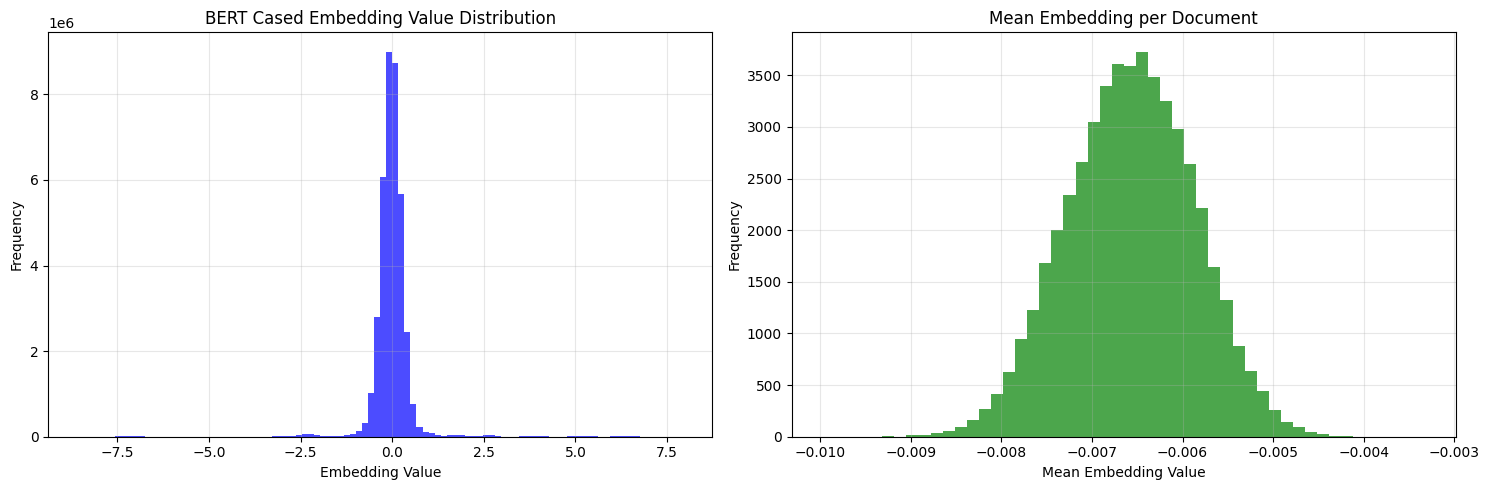


Statistics plotted!


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Embedding Statistics:\n")

# Basic stats
print(f"Shape: {embeddings.shape}")
print(f"Mean: {embeddings.mean():.4f}")
print(f"Std: {embeddings.std():.4f}")
print(f"Min: {embeddings.min():.4f}")
print(f"Max: {embeddings.max():.4f}")

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
axes[0].hist(embeddings.flatten(), bins=100, alpha=0.7, color='blue')
axes[0].set_xlabel('Embedding Value')
axes[0].set_ylabel('Frequency')
axes[0].set_title('BERT Cased Embedding Value Distribution')
axes[0].grid(True, alpha=0.3)

# Mean embedding per document
mean_embeddings = embeddings.mean(axis=1)
axes[1].hist(mean_embeddings, bins=50, alpha=0.7, color='green')
axes[1].set_xlabel('Mean Embedding Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Mean Embedding per Document')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistics plotted!")

Performing PCA on 1000 samples...
Explained variance: 18.51%


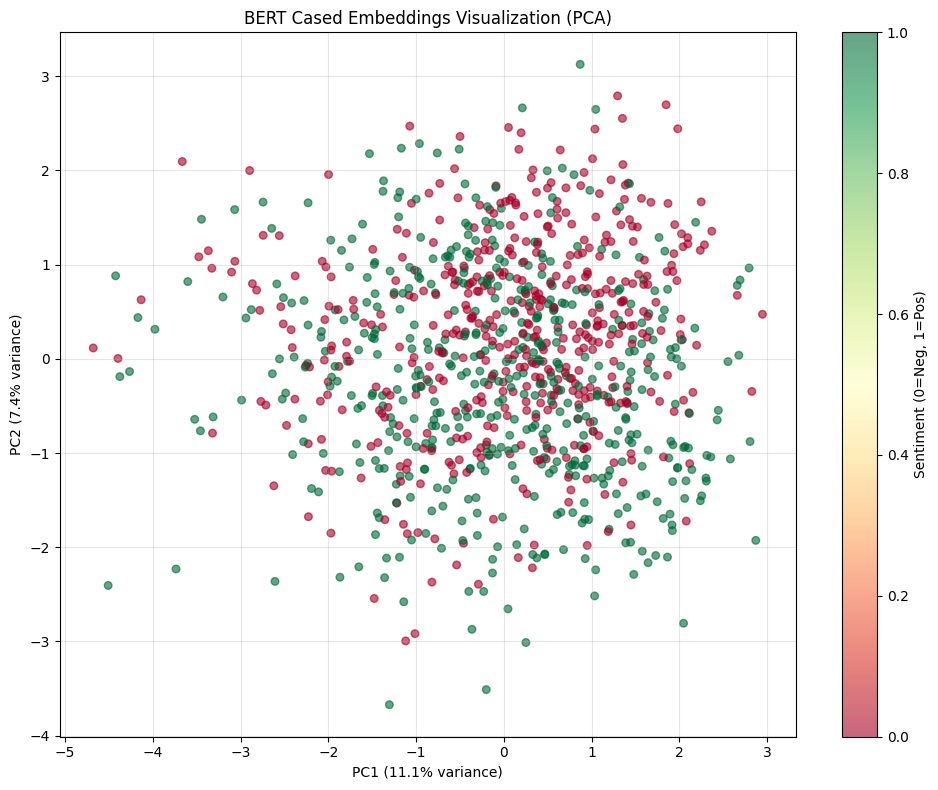


Visualization complete!


In [21]:
from sklearn.decomposition import PCA

# Sample for visualization
sample_size = 1000
indices = np.random.choice(len(embeddings), size=min(sample_size, len(embeddings)), replace=False)

sample_embeddings = embeddings[indices]
sample_labels = df['sentiment_label'].iloc[indices].values

# PCA reduction to 2D
print(f"Performing PCA on {len(sample_embeddings)} samples...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(sample_embeddings)

print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0],
    embeddings_2d[:, 1],
    c=sample_labels,
    cmap='RdYlGn',
    alpha=0.6,
    s=30
)
plt.colorbar(scatter, label='Sentiment (0=Neg, 1=Pos)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('BERT Cased Embeddings Visualization (PCA)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nVisualization complete!")

In [22]:
# Test case sensitivity
print("Testing case sensitivity of BERT Cased model:\n")

test_sentences = [
    ("this movie is great", "This movie is great"),
    ("the movie was EXCELLENT", "the movie was excellent"),
    ("I LOVED IT", "i loved it")
]

from sklearn.metrics.pairwise import cosine_similarity

for lower, upper in test_sentences:
    emb1 = get_bert_embedding(lower, tokenizer, model, device)
    emb2 = get_bert_embedding(upper, tokenizer, model, device)

    similarity = cosine_similarity([emb1], [emb2])[0][0]

    print(f"Sentence 1: '{lower}'")
    print(f"Sentence 2: '{upper}'")
    print(f"Cosine similarity: {similarity:.4f}")
    print(f"Different vectors: {not np.allclose(emb1, emb2)}")
    print("-" * 60)

print("\nNote: BERT Cased treats uppercase/lowercase differently!")

Testing case sensitivity of BERT Cased model:

Sentence 1: 'this movie is great'
Sentence 2: 'This movie is great'
Cosine similarity: 0.9957
Different vectors: True
------------------------------------------------------------
Sentence 1: 'the movie was EXCELLENT'
Sentence 2: 'the movie was excellent'
Cosine similarity: 0.9535
Different vectors: True
------------------------------------------------------------
Sentence 1: 'I LOVED IT'
Sentence 2: 'i loved it'
Cosine similarity: 0.9317
Different vectors: True
------------------------------------------------------------

Note: BERT Cased treats uppercase/lowercase differently!


In [23]:
print("\n" + "="*80)
print("BERT BASE CASED EMBEDDING EXTRACTION SUMMARY")
print("="*80)

print(f"\n Model: {MODEL_NAME}")
print(f" Case Sensitive: YES (preserves capitalization)")
print(f" Embedding dimension: {embeddings.shape[1]}")
print(f" Total documents: {embeddings.shape[0]:,}")
print(f" Total size: {embeddings.nbytes / (1024**2):.2f} MB")

print(f"\n Files saved:")
print(f"   {output_dir}/")
print(f"   ├── bert_cased_embeddings.npy  ({embeddings.shape})")
print(f"   ├── labels.npy                 ({loaded_labels.shape})")
print(f"   └── metadata.pkl")

print(f"\n Usage:")
print(f"   These embeddings can be used with any classifier:")
print(f"   - Logistic Regression")
print(f"   - SVM")
print(f"   - Random Forest")
print(f"   - Neural Networks")

print(f"\n Load embeddings:")
print(f"   X = np.load('{embeddings_path}')")
print(f"   y = np.load('{labels_path}')")

print(f"\n Difference from bert-base-uncased:")
print(f"   - Preserves uppercase/lowercase information")
print(f"   - Better for texts where case matters (e.g., proper nouns)")
print(f"   - May perform better on sentiment (e.g., 'GREAT' vs 'great')")

print("\n" + "="*80)
print(" BERT Cased embedding extraction complete!")
print("="*80)


BERT BASE CASED EMBEDDING EXTRACTION SUMMARY

 Model: bert-base-cased
 Case Sensitive: YES (preserves capitalization)
 Embedding dimension: 768
 Total documents: 50,000
 Total size: 146.48 MB

 Files saved:
   /content/drive/MyDrive/Shut up/models/bert_cased_embeddings/
   ├── bert_cased_embeddings.npy  ((50000, 768))
   ├── labels.npy                 ((50000,))
   └── metadata.pkl

 Usage:
   These embeddings can be used with any classifier:
   - Logistic Regression
   - SVM
   - Random Forest
   - Neural Networks

 Load embeddings:
   X = np.load('/content/drive/MyDrive/Shut up/models/bert_cased_embeddings/bert_cased_embeddings.npy')
   y = np.load('/content/drive/MyDrive/Shut up/models/bert_cased_embeddings/labels.npy')

 Difference from bert-base-uncased:
   - Preserves uppercase/lowercase information
   - Better for texts where case matters (e.g., proper nouns)
   - May perform better on sentiment (e.g., 'GREAT' vs 'great')

 BERT Cased embedding extraction complete!
